In [1]:
import tensorflow as tf
from os import path
import sys
tf.logging.set_verbosity(tf.logging.ERROR)
sys.path.append(path.join("../.."))

In [2]:
%%html
<style>
table {
    float: left;
}

.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>

In this example, we used two datasets of pancreatic cells. For gene markers, we used the Panglao Cell Type Marker database.

We used the Baron (2016) dataset for training the neural network (NN) because it has more cells and classes, and we used the Xin (2016) dataset for testing purposes because all of its classes are present in the Baron dataset.

In [3]:
EPOCHS = 100

In [4]:
import saly
import saly.backend as S
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


SPECIES = 'Human'
DATA_PATH = '/home/mlongar/Data/SingleCellGeneExpression/'
#DATA_PATH = '/Users/MarkDavidLongar/Documents/Coding/MachineLearning/Data/'
#DATA_PATH = 'D:/Data/SingleCellGeneExpression/'
DATASET_BARON_PATH = DATA_PATH + 'baron_2016h.h5ad' 
DATASET_XIN_PATH = DATA_PATH + 'xin_2016.h5ad'
MARKER_PATH = DATA_PATH + 'panglao_gene_markers.tab.gz'

Using TensorFlow backend.


# Load the data

In [5]:
baron_data, baron_labels = saly.load_h5ad(DATASET_BARON_PATH)
xin_data, xin_labels = saly.load_h5ad(DATASET_XIN_PATH)

### Baron

In [6]:
print(baron_data.shape)
baron_labels.value_counts()

(8569, 20125)


Beta cells          2525
Alpha cells         2326
Ductal cells        1077
Acinar cells         958
Delta cells          601
PaSC                 457
PP cells             255
Endothelial cell     252
Other                118
Name: labels, dtype: int64

Baron has 8569 cells and 20125 genes.

The cells are classified into 9 classes: Acinar cells, Alpha cells, Beta cells, Delta cells, Ductal cells, Endothelial cells, ***Other***, PaSC (i.e. Pancreatic stellate cells) and PP cells (i.e. Gamma cells).

### Xin

In [7]:
print(xin_data.shape)
xin_labels.value_counts()

(1492, 39851)


Alpha cells    886
Beta cells     472
PP cells        85
Delta cells     49
Name: labels, dtype: int64

Xin has 1492 cells and 39851 genes.

The cells are classified into 4 classes: Alpha cells, Beta cells, Delta cells and PP cells (i.e. Gamma cells).

# Drop rows

We removed every cell classified as 'Other' from the Baron dataset.

In [8]:
baron_data, baron_labels = saly.drop_rows(baron_data, baron_labels, ['Other', 'Alpha cells'])

unseen_data, unseen_labels = saly.drop_rows(xin_data, xin_labels, [c for c in xin_labels.unique() if c != 'Alpha cells'])
xin_data, xin_labels = saly.drop_rows(xin_data, xin_labels, ['Alpha cells'])

Dropped 2444 cell(s). New shape: (6125, 20125)
Dropped 606 cell(s). New shape: (886, 39851)
Dropped 886 cell(s). New shape: (606, 39851)


This removed 118 cells from Baron, leaving us with 8451 left.

# Load marker genes

We make sure to only load the Human marker genes.

In [9]:
markers_db = saly.load_markers(MARKER_PATH, SPECIES)

#### Get the markers and only keep those found in both datasets

In [10]:
markers = saly.get_mutual_markers([baron_data.columns, xin_data.columns], markers_db)

We do this because we want to train the network only on the marker genes found in both datasets, and drop the rest.

In [11]:
#print(len(S.get_used_markers(baron_data.columns, markers_db)), len(S.get_used_markers(xin_data.columns, markers_db)))
print(len(markers))

7545


Baron has 7618 markers, and Xin has 7610.

We used only those found in both datasets (7545).

*Note that in this context* ***Marker ≠ Marker Gene*** *because multiple cell types (i.e. markers) can have the same marker gene and so in this context, the number 7545 means 7545 connections in the partially-connected Marker Layer between the cell types and the genes.*

### Make sure every class is in the marker layer

Because some cell types are differently labelled in the marker database, we created a dictionary of aliases.

We also make sure to print out any label that cannot be found in either the list of markers or in the dictionary of aliases.

In [12]:
marker_aliases = {'PaSC' : 'Pancreatic stellate cells',
                  'PP cells' : 'Gamma (PP) cells',
                  'Endothelial cell' : 'Endothelial cells'}

saly.check_labels([baron_labels, xin_labels, unseen_labels], markers, marker_aliases)

# Drop unused genes

We used only the genes found in both datasets and the marker gene database, and therefore, we will connect with the partially-connected marker layer.

In [13]:
baron_data = saly.drop_unused_genes(baron_data, markers)
xin_data = saly.drop_unused_genes(xin_data, markers)
unseen_data = saly.drop_unused_genes(unseen_data, markers)

Dropped 15952 gene(s). New shape: (6125, 4173)
Dropped 35678 gene(s). New shape: (606, 4173)
Dropped 35678 gene(s). New shape: (886, 4173)


After this operation we are left with 4173 genes.

#### Make sure the data sets' shapes match

In [14]:
saly.check_shape([baron_data, xin_data, unseen_data])

# Data transformation

#### Preprocess the data

We shuffle, log10 transform and split the data into 70%, 15%, 15% splits.

In [15]:
(train_x, train_y), (validation_x, validation_y), (test_x, test_y) = saly.preprocess_data(baron_data, baron_labels,
                                                                                          train=0.7, validation=0.15,
                                                                                          test=0.15)

#### Log10 transform the Xin data, too

In [16]:
xin_data = S.log_10(xin_data)
unseen_data = S.log_10(unseen_data)

# Building the model

For the model we define a partially-connected Marker Layer.

The layer has a node for each cell type whose genes are present in both data sets.
In this case, there are 179 nodes in the marker layer representing 179 cell types. 

We only connect nodes (i.e. the cell types) in the marker layer to their marker genes at the input.

We constructed the partially connected marker layer by taking a dense layer and adding a connection mask (a binary matrix) to it, which we multiply with the output matrix.

We trained the network for 100 epochs.

For training the network we used two losses:

    1) A loss that measured the network's classification accuracy (cross entropy)
    
    2) A loss that measured the network's reconstruction accuracy (mean square error)
           During training we scaled the MSE score 100x to compensate for the losses' different scales

### The Architecture
|Layer|Nodes|
|-----|------|
|Input|4173 (genes)|
|Markers|179 (cell types)|
|Dense layer|100|
|**Bottleneck**|**25**|
|Dense layer|100|
|*Dropout*|*10%*|
|Output|4173 (genes)|

#### Create the model

In [20]:
model, marker_model, encoder_model = saly.build_model(baron_data, markers, supervised=True);

# Train the model

In [21]:
history = saly.train_model(model, train_x, train_y, markers, marker_aliases,
                           EPOCHS, validation_data=(xin_data, xin_labels), verbose=1);

Train on 4287 samples, validate on 606 samples
Epoch 1/100
4287/4287 [==============================] - 3s 609us/step - loss: 4.7238 - cell_activations_loss: 2.3490 - output_loss: 0.0237 - cell_activations_marker_prediction_metric: 0.7007 - val_loss: 21.1279 - val_cell_activations_loss: 0.0257 - val_output_loss: 0.2110 - val_cell_activations_marker_prediction_metric: 0.9884
Epoch 2/100
4287/4287 [==============================] - 1s 294us/step - loss: 1.6257 - cell_activations_loss: 0.0796 - output_loss: 0.0155 - cell_activations_marker_prediction_metric: 0.9841 - val_loss: 20.4612 - val_cell_activations_loss: 0.2198 - val_output_loss: 0.2024 - val_cell_activations_marker_prediction_metric: 0.9373
Epoch 3/100
4287/4287 [==============================] - 1s 308us/step - loss: 1.3065 - cell_activations_loss: 0.0246 - output_loss: 0.0128 - cell_activations_marker_prediction_metric: 0.9932 - val_loss: 19.8763 - val_cell_activations_loss: 0.0032 - val_output_loss: 0.1987 - val_cell_activati

4287/4287 [==============================] - 1s 311us/step - loss: 0.9847 - cell_activations_loss: 5.3622e-04 - output_loss: 0.0098 - cell_activations_marker_prediction_metric: 1.0000 - val_loss: 17.6933 - val_cell_activations_loss: 0.0147 - val_output_loss: 0.1768 - val_cell_activations_marker_prediction_metric: 0.9983
Epoch 26/100
4287/4287 [==============================] - 1s 312us/step - loss: 0.9827 - cell_activations_loss: 5.0412e-04 - output_loss: 0.0098 - cell_activations_marker_prediction_metric: 1.0000 - val_loss: 17.6235 - val_cell_activations_loss: 0.0159 - val_output_loss: 0.1761 - val_cell_activations_marker_prediction_metric: 0.9967
Epoch 27/100
4287/4287 [==============================] - 1s 284us/step - loss: 0.9797 - cell_activations_loss: 4.8088e-04 - output_loss: 0.0098 - cell_activations_marker_prediction_metric: 1.0000 - val_loss: 17.6794 - val_cell_activations_loss: 0.0164 - val_output_loss: 0.1766 - val_cell_activations_marker_prediction_metric: 0.9983
Epoch 28

4287/4287 [==============================] - 1s 277us/step - loss: 0.9481 - cell_activations_loss: 2.0688e-04 - output_loss: 0.0095 - cell_activations_marker_prediction_metric: 1.0000 - val_loss: 17.4052 - val_cell_activations_loss: 0.0176 - val_output_loss: 0.1739 - val_cell_activations_marker_prediction_metric: 0.9967
Epoch 50/100
4287/4287 [==============================] - 1s 268us/step - loss: 0.9471 - cell_activations_loss: 2.0164e-04 - output_loss: 0.0095 - cell_activations_marker_prediction_metric: 1.0000 - val_loss: 17.4289 - val_cell_activations_loss: 0.0175 - val_output_loss: 0.1741 - val_cell_activations_marker_prediction_metric: 0.9967
Epoch 51/100
4287/4287 [==============================] - 1s 267us/step - loss: 0.9468 - cell_activations_loss: 1.9740e-04 - output_loss: 0.0095 - cell_activations_marker_prediction_metric: 1.0000 - val_loss: 17.4664 - val_cell_activations_loss: 0.0168 - val_output_loss: 0.1745 - val_cell_activations_marker_prediction_metric: 0.9967
Epoch 52

4287/4287 [==============================] - 1s 279us/step - loss: 0.9122 - cell_activations_loss: 1.2061e-04 - output_loss: 0.0091 - cell_activations_marker_prediction_metric: 1.0000 - val_loss: 17.1882 - val_cell_activations_loss: 0.0154 - val_output_loss: 0.1717 - val_cell_activations_marker_prediction_metric: 0.9967
Epoch 74/100
4287/4287 [==============================] - 1s 278us/step - loss: 0.9113 - cell_activations_loss: 1.1804e-04 - output_loss: 0.0091 - cell_activations_marker_prediction_metric: 1.0000 - val_loss: 17.1366 - val_cell_activations_loss: 0.0161 - val_output_loss: 0.1712 - val_cell_activations_marker_prediction_metric: 0.9967
Epoch 75/100
4287/4287 [==============================] - 1s 280us/step - loss: 0.9109 - cell_activations_loss: 1.1672e-04 - output_loss: 0.0091 - cell_activations_marker_prediction_metric: 1.0000 - val_loss: 17.1576 - val_cell_activations_loss: 0.0166 - val_output_loss: 0.1714 - val_cell_activations_marker_prediction_metric: 0.9967
Epoch 76

4287/4287 [==============================] - 1s 292us/step - loss: 0.9004 - cell_activations_loss: 8.1102e-05 - output_loss: 0.0090 - cell_activations_marker_prediction_metric: 1.0000 - val_loss: 17.0292 - val_cell_activations_loss: 0.0140 - val_output_loss: 0.1702 - val_cell_activations_marker_prediction_metric: 0.9967
Epoch 98/100
4287/4287 [==============================] - 1s 284us/step - loss: 0.9007 - cell_activations_loss: 8.1362e-05 - output_loss: 0.0090 - cell_activations_marker_prediction_metric: 1.0000 - val_loss: 17.0345 - val_cell_activations_loss: 0.0146 - val_output_loss: 0.1702 - val_cell_activations_marker_prediction_metric: 0.9967
Epoch 99/100
4287/4287 [==============================] - 1s 294us/step - loss: 0.8985 - cell_activations_loss: 8.1702e-05 - output_loss: 0.0090 - cell_activations_marker_prediction_metric: 1.0000 - val_loss: 17.0082 - val_cell_activations_loss: 0.0150 - val_output_loss: 0.1699 - val_cell_activations_marker_prediction_metric: 0.9967
Epoch 10

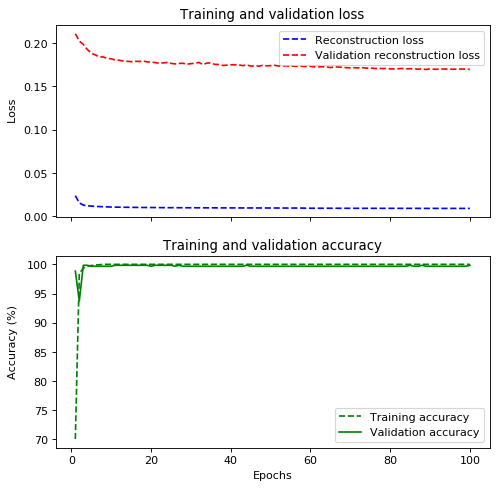

Test reconstruction loss: 0.00923413
Test prediction accuracy: 98.966 %


In [22]:
saly.plot_model_history(history)
saly.test_model(model, test_x, test_y, markers, marker_aliases);

# Data analysis

In [23]:
from sklearn.manifold import TSNE
tsne = TSNE()
colours = S.load_label_colours('../Data/baron_xin_label_colours.pickle') 

## Baron predictions

In [24]:
baron_cell_activations = marker_model.predict(test_x)
baron_bottleneck_activations = encoder_model.predict(test_x)

In [25]:
saly.get_results(test_y, baron_cell_activations, markers, marker_aliases)

Correct predictions: 1819 out of 1838 (98.97%)


In [43]:
saly.get_average_auc(test_y, baron_cell_activations, markers, marker_aliases)

Average ROC AUC: 0.948


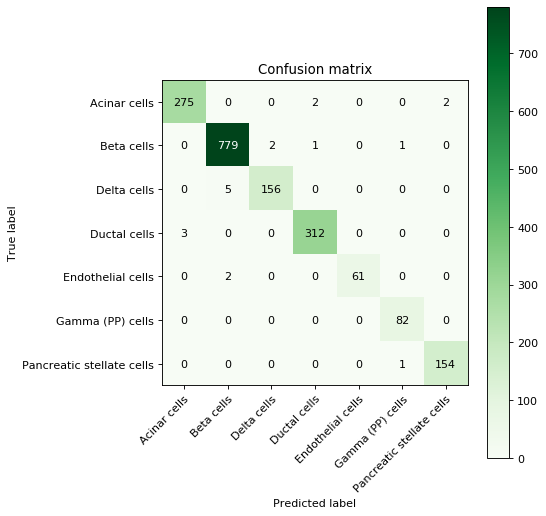

In [27]:
saly.draw_confusion_matrix(test_y, baron_cell_activations, markers, marker_aliases)

The graph below shows the mean cell type activations. Note that only one cell type explicitly activates.

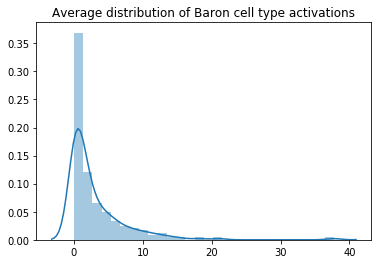

In [28]:
saly.plot_activation_distribution(baron_cell_activations, markers,
                                  title='Average distribution of Baron cell type activations')

## Unseen cells

In [29]:
unseen_cell_activations = marker_model.predict(unseen_data)

In [30]:
saly.get_results(unseen_labels, unseen_cell_activations, markers, marker_aliases)

Correct predictions: 0 out of 886 (0.0%)


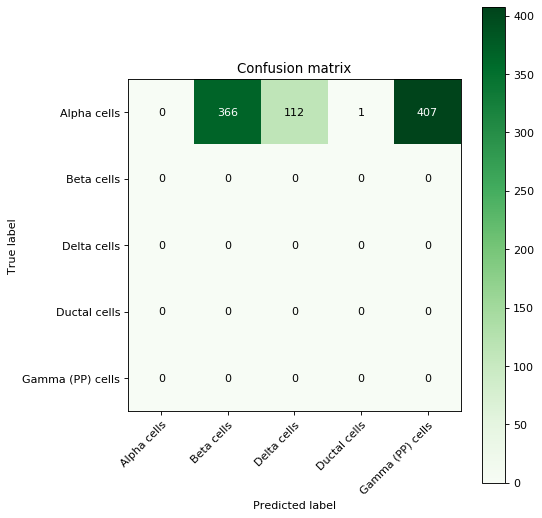

In [31]:
saly.draw_confusion_matrix(unseen_labels, unseen_cell_activations, markers, marker_aliases)

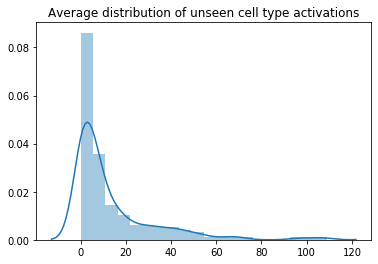

In [42]:
saly.plot_activation_distribution(unseen_cell_activations, markers,
                                  title='Average distribution of unseen cell type activations')

## Xin predictions

In [32]:
xin_cell_activations = marker_model.predict(xin_data)

The network correctly classifies almost 100% of data from a completely new data set.

In [34]:
saly.get_average_auc(xin_labels, xin_cell_activations, markers, marker_aliases)

Average ROC AUC: 0.945


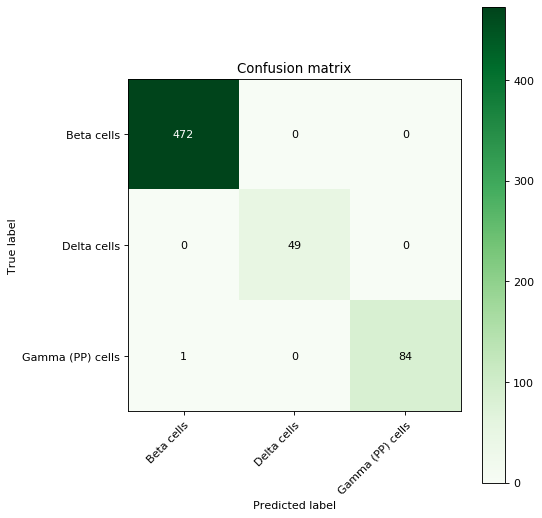

In [33]:
saly.draw_confusion_matrix(xin_labels, xin_cell_activations, markers, marker_aliases)

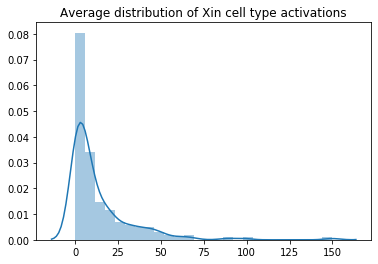

In [35]:
saly.plot_activation_distribution(xin_cell_activations, markers,
                                  title='Average distribution of Xin cell type activations')

In [36]:
saly.get_results(xin_labels, xin_cell_activations, markers, marker_aliases)

Correct predictions: 605 out of 606 (99.83%)


# Reconstruction

Here we took the Xin data set and run them through the autoencoder.

Then we took the autoencoder's output (i.e. the reconstructed data) and ran that data through the autoencoder again, this time looking at the Marker layer's cell type activations.

The cell type activations of the reconstructed data give similar, sometimes worse, but almost never better results.

In [37]:
reconstruction = model.predict(xin_data)[1]
reconstruction = pd.DataFrame(reconstruction, columns=xin_data.columns)
reconstructed_cell_activations = marker_model.predict(reconstruction)
reconstructed_bottleneck_activations = encoder_model.predict(reconstruction)

In [38]:
saly.get_results(xin_labels, reconstructed_cell_activations, markers, marker_aliases)

Correct predictions: 594 out of 606 (98.02%)


In [39]:
saly.get_average_auc(xin_labels, reconstructed_cell_activations, markers, marker_aliases)

Average ROC AUC: 0.872


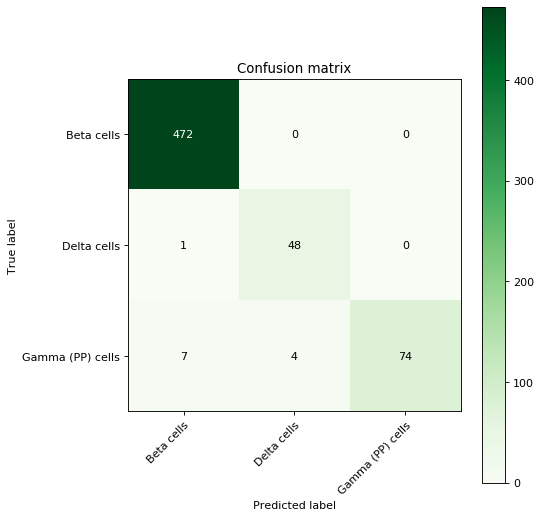

In [40]:
saly.draw_confusion_matrix(xin_labels, reconstructed_cell_activations, markers, marker_aliases)

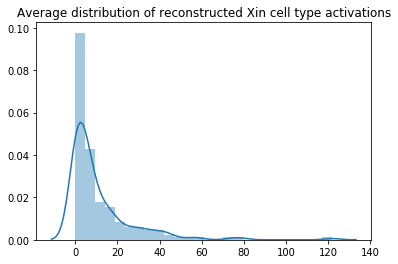

In [41]:
saly.plot_activation_distribution(reconstructed_cell_activations, markers,
                                  title='Average distribution of reconstructed Xin cell type activations')